In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset.csv")  

In [3]:
t_min = df['timestamp'].min()
t_max = df['timestamp'].max()

print("Raw timestamp range:", t_min, "to", t_max)

time_range_s = (t_max - t_min) / 1e9  # nano seconds
print("Total duration (seconds):", time_range_s)
print("Total duration (minutes):", time_range_s / 60)
print("Total duration (hours):", time_range_s / 3600)

Raw timestamp range: 73452342000 to 209397361451000
Total duration (seconds): 209323.909109
Total duration (minutes): 3488.7318184833334
Total duration (hours): 58.145530308055555


In [4]:
print(df.head())

   user activity      timestamp  x-axis  y-axis  z-axis
0     1  Walking  4991922345000    0.69   10.80   -2.03
1     1  Walking  4991972333000    6.85    7.44   -0.50
2     1  Walking  4992022351000    0.93    5.63   -0.50
3     1  Walking  4992072339000   -2.11    5.01   -0.69
4     1  Walking  4992122358000   -4.59    4.29   -1.95


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073623 entries, 0 to 1073622
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1073623 non-null  int64  
 1   activity   1073623 non-null  object 
 2   timestamp  1073623 non-null  int64  
 3   x-axis     1073623 non-null  float64
 4   y-axis     1073623 non-null  float64
 5   z-axis     1073623 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 49.1+ MB
None


In [6]:
print(df['activity'].value_counts())

activity
Walking       417901
Jogging       324600
Upstairs      122598
Downstairs    100192
Sitting        59939
Standing       48393
Name: count, dtype: int64


In [7]:
print(f"Number of users for which data was recorded {len(df['user'].unique())}")

Number of users for which data was recorded 36


Number of users per number of activities:
activity
1     1
2     2
4    10
5     4
6    19
Name: count, dtype: int64


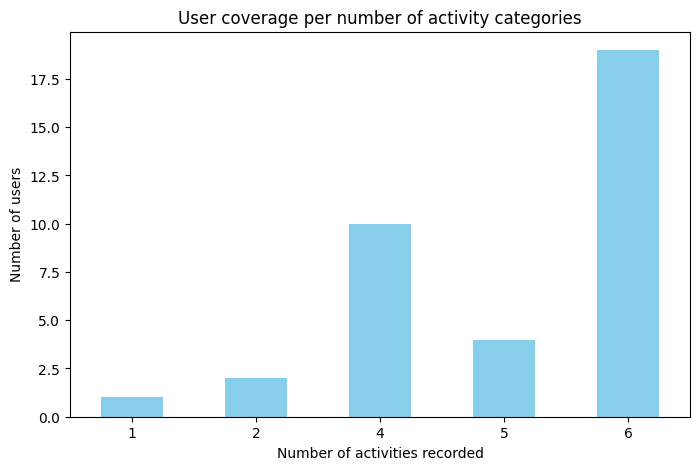

In [8]:
activity_counts_per_user = df.groupby("user")["activity"].nunique()

# count how many users have 1, 2, 3... activities
users_per_activity_count = activity_counts_per_user.value_counts().sort_index()

print("Number of users per number of activities:")
print(users_per_activity_count)

# plot
plt.figure(figsize=(8,5))
users_per_activity_count.plot(kind='bar', color='skyblue')
plt.xlabel("Number of activities recorded")
plt.ylabel("Number of users")
plt.title("User coverage per number of activity categories")
plt.xticks(rotation=0)
plt.show()

In [9]:
user_activity_matrix = pd.crosstab(df['user'], df['activity'])

print(user_activity_matrix)

activity  Downstairs  Jogging  Sitting  Standing  Upstairs  Walking
user                                                               
1               2941    11056        0         0      3120    12861
2                  0    11786        0         0         0    11739
3               3326    11018     1609      2824      3411    12970
4               1761      895     1257         0      1377     6079
5               3281     6405     1664      1515      3387    12257
6               1431    10961     1679       709      1661    12262
7               2257     9183     2529      2364      3601    11033
8               3345    10313     2699      3269      4453    17108
9                  0        0        0         0         0    12923
10              3792    12084        0      1659      4294    13046
11              2674    12454        0         0      4392    12138
12              2870    12360     2289      1670      2654    10798
13              4240    11301     1179      1659

In [10]:
import numpy as np
import json
from IPython.display import display, clear_output
from ipywidgets import Button, Text, VBox, HBox, Label, Textarea, IntText, Dropdown
import ipywidgets as widgets

# Create windows from the dataset
def create_windows(df, window_size_s=3, overlap=0.5):
    """
    Create sliding windows from the dataframe
    window_size_s: window size in seconds
    overlap: fraction of overlap (0.5 = 50% overlap)
    """
    windows = []
    
    for user in sorted(df['user'].unique()):
        for activity in df['activity'].unique():
            df_subset = df[(df['user'] == user) & (df['activity'] == activity)].copy()
            
            if df_subset.empty:
                continue
            
            # Sort by timestamp
            df_subset = df_subset.sort_values('timestamp').reset_index(drop=True)
            
            # Convert timestamp to seconds from start
            t0 = df_subset['timestamp'].iloc[0]
            df_subset['time_s'] = (df_subset['timestamp'] - t0) / 1e9
            
            # Create windows
            t_max = df_subset['time_s'].max()
            step = window_size_s * (1 - overlap)
            
            window_start = 0
            while window_start + window_size_s <= t_max:
                window_end = window_start + window_size_s
                
                window_data = df_subset[
                    (df_subset['time_s'] >= window_start) & 
                    (df_subset['time_s'] < window_end)
                ].copy()
                
                if len(window_data) > 10:  # Only keep windows with enough data points
                    windows.append({
                        'user': user,
                        'activity': activity,
                        'start_time': window_start,
                        'end_time': window_end,
                        'data': window_data
                    })
                
                window_start += step
    
    return windows

# ========================================
# CONFIGURATION: Adjust these to control how many windows to label
# ========================================

# Option 1: Select specific users (None = all users)
selected_users = [1, 2, 3, 4, 5]  # Label only users 1-5 to start
# selected_users = None  # Uncomment to use all users

# Option 2: Select specific activities (None = all activities)
selected_activities = None  # Use all activities
# selected_activities = ['Walking', 'Jogging']  # Uncomment to limit to specific activities

# Option 3: Reduce overlap to create fewer windows
overlap_ratio = 0.75  # 0.75 = 75% overlap (more windows), 0.0 = no overlap (fewer windows)

# Option 4: Limit total windows (useful for testing)
max_windows = 100  # Set to a number like 100 to limit for testing
# max_windows = 100  # Uncomment to test with only 100 windows

# ========================================

# Filter dataframe if needed
df_filtered = df.copy()
if selected_users is not None:
    df_filtered = df_filtered[df_filtered['user'].isin(selected_users)]
if selected_activities is not None:
    df_filtered = df_filtered[df_filtered['activity'].isin(selected_activities)]

print(f"Dataset: {len(df_filtered)} samples")
print(f"Users: {sorted(df_filtered['user'].unique())}")
print(f"Activities: {sorted(df_filtered['activity'].unique())}")
print()
print("Creating windows... (this may take a moment)")

windows = create_windows(df_filtered, window_size_s=3, overlap=overlap_ratio)

if max_windows is not None and len(windows) > max_windows:
    print(f"Limiting to first {max_windows} windows (out of {len(windows)} total)")
    windows = windows[:max_windows]

print(f"✓ Created {len(windows)} windows to label")


Dataset: 128539 samples


Users: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Activities: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

Creating windows... (this may take a moment)
Limiting to first 100 windows (out of 8558 total)
✓ Created 100 windows to label


# 📊 Interactive Window Labeling Tool for Concept Bottleneck Model

This tool helps you efficiently label windows of accelerometer data with **continuous concept values (0-1)** for your Concept Bottleneck Model.

## Features:
- **Slider-based labeling**: Rate each concept from 0 (absent) to 1 (fully present)
- **High-resolution visualization**: Each window is displayed with separate plots for X, Y, Z axes and a combined view
- **Interactive navigation**: Navigate with Previous/Next buttons or jump to specific windows
- **Auto-save to CSV**: Labels are automatically saved to `window_labels.csv` after each entry
- **Progress tracking**: See your progress and how many windows remain
- **Resume capability**: Continue labeling from where you left off (loads existing labels)

## Concept Configuration:
The following concepts require **manual labeling** (configured in Cell 11):
- **`periodicity`**: How periodic/rhythmic is the motion? (0=random, 1=highly periodic)
- **`temporal_stability`**: How stable/consistent is the motion over time? (0=erratic, 1=very stable)
- **`coordination`**: How coordinated are the movements? (0=uncoordinated, 1=highly coordinated)

Note: Other concepts (e.g., direction, intensity, body position) can be computed rule-based from the sensor data and don't need manual labeling.

## How to Use:
1. (Optional) Customize concepts in Cell 11
2. Run cells 9, 11, 12, 13 to initialize the labeler
3. View the current window's accelerometer data in the plots
4. **Rate each concept** using the sliders (0 = absent, 1 = fully present, 0.5 = moderate)
5. Click "💾 Save & Next" to save and automatically advance to the next window
6. Use "↺ Reset All to 0" to quickly reset sliders
7. Your labels are automatically saved to `window_labels.csv`

## Tips:
- Labels are saved as CSV with continuous values (0-1) for each concept
- The CSV includes: window_idx, user, activity, start_time, end_time, and all concept values
- You can easily merge this with your original dataset for training
- Use "Export to CSV" to ensure all data is saved
- Jump to specific windows if you want to review/edit previous labels


In [11]:
# ========================================
# CONCEPT CONFIGURATION
# ========================================
# Define your concepts here - these will be manually labeled (0-1 continuous values)
# Other concepts (like direction, intensity) can be computed rule-based from sensor data
CONCEPTS = [
    'periodicity',          # How periodic/rhythmic is the motion? (0=random, 1=highly periodic)
    'temporal_stability',   # How stable/consistent is the motion over time? (0=erratic, 1=very stable)
    'coordination'          # How coordinated are the movements? (0=uncoordinated, 1=highly coordinated)
]
# ========================================

class WindowLabeler:
    def __init__(self, windows, concepts, labels_file='window_labels.csv'):
        self.windows = windows
        self.concepts = concepts
        self.labels_file = labels_file
        self.current_idx = 0
        self.labels = {}
        
        # Load existing labels if they exist
        self.load_labels()
        
        # Create UI components
        self.output = widgets.Output()
        self.info_label = Label(value="")
        self.progress_label = Label(value="")
        
        # Navigation buttons
        self.prev_btn = Button(description='◀ Previous', button_style='info')
        self.next_btn = Button(description='Next ▶', button_style='info')
        self.jump_input = IntText(value=0, description='Go to:', style={'description_width': '50px'})
        self.jump_btn = Button(description='Jump', button_style='warning')
        
        # Create sliders for each concept (0 to 1 range)
        self.concept_sliders = {}
        slider_widgets = []
        
        for concept in self.concepts:
            slider = widgets.FloatSlider(
                value=0.0,
                min=0.0,
                max=1.0,
                step=0.05,
                description=concept + ':',
                readout=True,
                readout_format='.2f',
                style={'description_width': '150px'},
                layout=widgets.Layout(width='600px')
            )
            self.concept_sliders[concept] = slider
            slider_widgets.append(slider)
        
        # Reset button to set all sliders to 0
        self.reset_btn = Button(description='↺ Reset All to 0', button_style='')
        self.reset_btn.on_click(self.on_reset)
        
        # Action buttons
        self.save_label_btn = Button(description='💾 Save & Next', button_style='success')
        self.save_all_btn = Button(description='💾 Export to CSV', button_style='primary')
        self.skip_btn = Button(description='Skip', button_style='')
        
        # Statistics
        self.stats_label = Label(value="")
        
        # Connect button callbacks
        self.prev_btn.on_click(self.on_prev)
        self.next_btn.on_click(self.on_next)
        self.jump_btn.on_click(self.on_jump)
        self.save_label_btn.on_click(self.on_save_label)
        self.save_all_btn.on_click(self.on_save_all)
        self.skip_btn.on_click(self.on_skip)
        
        # Layout
        nav_box = HBox([self.prev_btn, self.next_btn, self.jump_input, self.jump_btn])
        
        # Organize sliders in two columns for better space usage
        mid = len(slider_widgets) // 2
        left_sliders = VBox(slider_widgets[:mid])
        right_sliders = VBox(slider_widgets[mid:])
        sliders_box = HBox([left_sliders, right_sliders])
        
        label_box = VBox([
            Label(value="Rate each concept from 0 (absent) to 1 (fully present):", 
                  style={'font_weight': 'bold'}),
            sliders_box,
            self.reset_btn
        ])
        
        action_box = HBox([self.save_label_btn, self.skip_btn, self.save_all_btn])
        
        self.ui = VBox([
            self.info_label,
            self.progress_label,
            self.output,
            Label(value="──────────────────────────────────────────────────────────"),
            label_box,
            action_box,
            nav_box,
            self.stats_label
        ])
        
    def load_labels(self):
        """Load existing labels from CSV file"""
        try:
            df_labels = pd.read_csv(self.labels_file)
            # Convert to dictionary format: {window_idx: {concept: value, ...}}
            for _, row in df_labels.iterrows():
                window_idx = int(row['window_idx'])
                self.labels[window_idx] = {col: float(row[col]) for col in self.concepts}
            print(f"Loaded {len(self.labels)} existing labels from {self.labels_file}")
        except FileNotFoundError:
            print(f"No existing labels file found. Starting fresh.")
            self.labels = {}
        except Exception as e:
            print(f"⚠️  Error loading labels file: {e}")
            print(f"   Starting fresh.")
            self.labels = {}
    
    def save_labels_to_file(self):
        """Save all labels to CSV file"""
        try:
            # Convert labels dictionary to DataFrame format
            rows = []
            for window_idx in sorted(self.labels.keys()):
                window = self.windows[window_idx]
                row = {
                    'window_idx': int(window_idx),
                    'user': int(window['user']),
                    'activity': str(window['activity']),
                    'start_time': float(window['start_time']),
                    'end_time': float(window['end_time'])
                }
                # Add concept values
                for concept in self.concepts:
                    row[concept] = float(self.labels[window_idx].get(concept, 0.0))
                rows.append(row)
            
            df_labels = pd.DataFrame(rows)
            df_labels.to_csv(self.labels_file, index=False)
            return len(self.labels)
            
        except Exception as e:
            print(f"⚠️  Error saving labels: {e}")
            raise e
    
    def plot_window(self, window_idx, show_combined=True):
        """Plot a single window with high resolution"""
        if window_idx < 0 or window_idx >= len(self.windows):
            return
        
        window = self.windows[window_idx]
        data = window['data']
        
        with self.output:
            clear_output(wait=True)
            
            # Create high-resolution figure (optimized for speed)
            fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
            fig.suptitle(f"Window {window_idx}", fontsize=16, fontweight='bold')
            
            # Plot each axis separately for clarity (removed markers for faster rendering)
            axes[0].plot(data['time_s'], data['x-axis'], 'b-', linewidth=1.5)
            axes[0].set_ylabel('X-axis', fontsize=12, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
            axes[0].set_title('X-axis Acceleration', fontsize=11)
            
            axes[1].plot(data['time_s'], data['y-axis'], 'g-', linewidth=1.5)
            axes[1].set_ylabel('Y-axis', fontsize=12, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
            axes[1].set_title('Y-axis Acceleration', fontsize=11)
            
            axes[2].plot(data['time_s'], data['z-axis'], 'r-', linewidth=1.5)
            axes[2].set_ylabel('Z-axis', fontsize=12, fontweight='bold')
            axes[2].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
            axes[2].grid(True, alpha=0.3)
            axes[2].set_title('Z-axis Acceleration', fontsize=11)
            
            plt.tight_layout()
            plt.show()
            
            # Add combined plot (optional, can be disabled for faster rendering)
            if show_combined:
                fig2, ax = plt.subplots(1, 1, figsize=(14, 5))
                ax.plot(data['time_s'], data['x-axis'], 'b-', linewidth=1.5, label='X-axis', alpha=0.7)
                ax.plot(data['time_s'], data['y-axis'], 'g-', linewidth=1.5, label='Y-axis', alpha=0.7)
                ax.plot(data['time_s'], data['z-axis'], 'r-', linewidth=1.5, label='Z-axis', alpha=0.7)
                ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
                ax.set_ylabel('Acceleration', fontsize=12, fontweight='bold')
                ax.set_title('Combined View - All Axes', fontsize=14, fontweight='bold')
                ax.legend(loc='best', fontsize=11)
                ax.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
    
    def update_display(self):
        """Update the display for current window"""
        window = self.windows[self.current_idx]
        
        # Update info
        self.info_label.value = (
            f"User: {window['user']} | "
            f"Activity: {window['activity']} | "
            f"Time: {window['start_time']:.2f}s - {window['end_time']:.2f}s | "
            f"Data points: {len(window['data'])}"
        )
        
        # Update progress
        labeled_count = len(self.labels)
        self.progress_label.value = (
            f"Window {self.current_idx + 1} of {len(self.windows)} | "
            f"Labeled: {labeled_count} ({100*labeled_count/len(self.windows):.1f}%)"
        )
        
        # Load existing label if available
        if self.current_idx in self.labels:
            existing = self.labels[self.current_idx]
            for concept in self.concepts:
                self.concept_sliders[concept].value = existing.get(concept, 0.0)
            self.stats_label.value = f"✓ This window already has a label"
        else:
            # Reset all sliders to 0
            for concept in self.concepts:
                self.concept_sliders[concept].value = 0.0
            self.stats_label.value = f"○ This window needs a label"
        
        # Update jump input
        self.jump_input.value = self.current_idx
        
        # Plot the window
        self.plot_window(self.current_idx)
    
    def on_prev(self, btn):
        if self.current_idx > 0:
            self.current_idx -= 1
            self.update_display()
    
    def on_next(self, btn):
        if self.current_idx < len(self.windows) - 1:
            self.current_idx += 1
            self.update_display()
    
    def on_jump(self, btn):
        idx = self.jump_input.value
        if 0 <= idx < len(self.windows):
            self.current_idx = idx
            self.update_display()
    
    def on_save_label(self, btn):
        """Save the current label"""
        # Get concept values from sliders
        concept_values = {}
        for concept in self.concepts:
            concept_values[concept] = float(self.concept_sliders[concept].value)
        
        # Save label
        self.labels[self.current_idx] = concept_values
        
        # Auto-save to file
        count = self.save_labels_to_file()
        self.stats_label.value = f"✓ Label saved! Total labels: {count}"
        
        # Auto-advance to next window
        if self.current_idx < len(self.windows) - 1:
            self.current_idx += 1
            self.update_display()
    
    def on_reset(self, btn):
        """Reset all sliders to 0"""
        for concept in self.concepts:
            self.concept_sliders[concept].value = 0.0
    
    def on_skip(self, btn):
        """Skip to next window without saving"""
        if self.current_idx < len(self.windows) - 1:
            self.current_idx += 1
            self.update_display()
    
    def on_save_all(self, btn):
        """Save all labels to file"""
        count = self.save_labels_to_file()
        self.stats_label.value = f"✓ Saved {count} labels to {self.labels_file}"
    
    def display(self):
        """Display the labeler interface"""
        display(self.ui)
        self.update_display()

# Create and display the labeler
print("Initializing labeler...")
print(f"Concepts to label: {', '.join(CONCEPTS)}")
print(f"Windows to label: {len(windows)}")
labeler = WindowLabeler(windows, concepts=CONCEPTS, labels_file='window_labels.csv')
print("Ready to label! Use the interface below:")


Initializing labeler...
Concepts to label: periodicity, temporal_stability, coordination
Windows to label: 100
No existing labels file found. Starting fresh.
Ready to label! Use the interface below:


In [12]:
# Display the interactive labeler
labeler.display()


In [13]:
# Helper functions to analyze labels after labeling is complete

def load_and_analyze_labels(labels_file='window_labels.csv', concepts=CONCEPTS):
    """Load labels from CSV and show statistics"""
    try:
        df_labels = pd.read_csv(labels_file)
        
        print(f"Total labeled windows: {len(df_labels)}")
        print()
        
        # Show distribution by activity
        print("Labels by activity:")
        activity_counts = df_labels['activity'].value_counts()
        for activity, count in activity_counts.items():
            print(f"  {activity}: {count}")
        
        print("\nConcept statistics (mean values 0-1):")
        for concept in concepts:
            mean_val = df_labels[concept].mean()
            std_val = df_labels[concept].std()
            print(f"  {concept}: mean={mean_val:.3f}, std={std_val:.3f}")
        
        print("\nConcept statistics by activity:")
        for activity in sorted(df_labels['activity'].unique()):
            print(f"\n{activity}:")
            activity_data = df_labels[df_labels['activity'] == activity]
            for concept in concepts:
                mean_val = activity_data[concept].mean()
                print(f"  {concept}: {mean_val:.3f}")
        
        return df_labels
        
    except FileNotFoundError:
        print(f"No labels file found at {labels_file}")
        return None
    except Exception as e:
        print(f"Error loading labels: {e}")
        return None

# Uncomment to run after labeling:
# labeled_data = load_and_analyze_labels()


## 🚀 Quick Start Guide

**Before running the labeler on all 36K+ windows**, here's what you should know:

### Current Issue:
The original configuration creates **36,384 windows** which is:
- ❌ Too many to label manually
- ❌ Takes a long time to load
- ❌ Uses a lot of memory

### ✅ **RECOMMENDED APPROACH:**

1. **Start small** - Test with 100 windows first
2. **Choose specific users** - Label 5-10 users at a time
3. **Adjust overlap** - Use less overlap (e.g., 0% or 25% instead of 75%)

### Configuration Options (in Cell 9):

```python
# Example 1: Test with 100 windows
max_windows = 100

# Example 2: Label only specific users (5 users ≈ 5,000-8,000 windows)
selected_users = [1, 2, 3, 4, 5]

# Example 3: Reduce overlap to create fewer windows
overlap_ratio = 0.0  # No overlap = ~18K windows instead of 36K
```

**💡 TIP:** Start by uncommenting `max_windows = 100` in Cell 9, then re-run cells 9-13 to test!


## 📤 After Labeling: Export Your Data

Once you've labeled your windows, you have two output files:

### 1. `window_labels.csv` (Window-level labels)
- One row per window
- Columns: `window_idx`, `user`, `activity`, `start_time`, `end_time`, + all concept values (0-1)
- Use this for window-level classification tasks

### 2. `labeled_windows.csv` (Sample-level labels - use export function)
- Created by running: `labeled_dataset = export_labeled_windows()`
- One row per timestamp (sample)
- Includes all accelerometer data + concept labels
- Use this for sample-level training or data analysis

### Example Usage:
```python
# Analyze your labels
labeled_data = load_and_analyze_labels()

# Export to sample-level dataset
labeled_dataset = export_labeled_windows()

# Now you can use labeled_dataset for training your CBM!
```


In [14]:
# Helper function to merge labels with original windows data

def export_labeled_windows(labels_file='window_labels.csv', output_file='labeled_windows.csv'):
    """
    Export labeled windows in a format ready for training your CBM.
    Each window becomes multiple rows (one per timestamp in the window),
    with concept labels replicated across all rows in that window.
    """
    try:
        df_labels = pd.read_csv(labels_file)
        print(f"Loaded {len(df_labels)} labeled windows")
        
        # Create a dataset where each row is a timestamp with concept labels
        all_rows = []
        
        for _, label_row in df_labels.iterrows():
            window_idx = int(label_row['window_idx'])
            window = windows[window_idx]
            window_data = window['data']
            
            # Add concept columns to each data point in the window
            for _, data_row in window_data.iterrows():
                new_row = {
                    'window_idx': window_idx,
                    'user': int(window['user']),
                    'activity': str(window['activity']),
                    'timestamp': data_row['timestamp'],
                    'x-axis': data_row['x-axis'],
                    'y-axis': data_row['y-axis'],
                    'z-axis': data_row['z-axis']
                }
                # Add all concept values
                for concept in CONCEPTS:
                    new_row[concept] = float(label_row[concept])
                
                all_rows.append(new_row)
        
        df_export = pd.DataFrame(all_rows)
        df_export.to_csv(output_file, index=False)
        
        print(f"\n✓ Exported {len(df_export)} data points to {output_file}")
        print(f"  Columns: {list(df_export.columns)}")
        print(f"  Shape: {df_export.shape}")
        
        return df_export
        
    except FileNotFoundError:
        print(f"Labels file not found: {labels_file}")
        return None
    except Exception as e:
        print(f"Error exporting: {e}")
        return None

# Uncomment to export after labeling:
# labeled_dataset = export_labeled_windows()


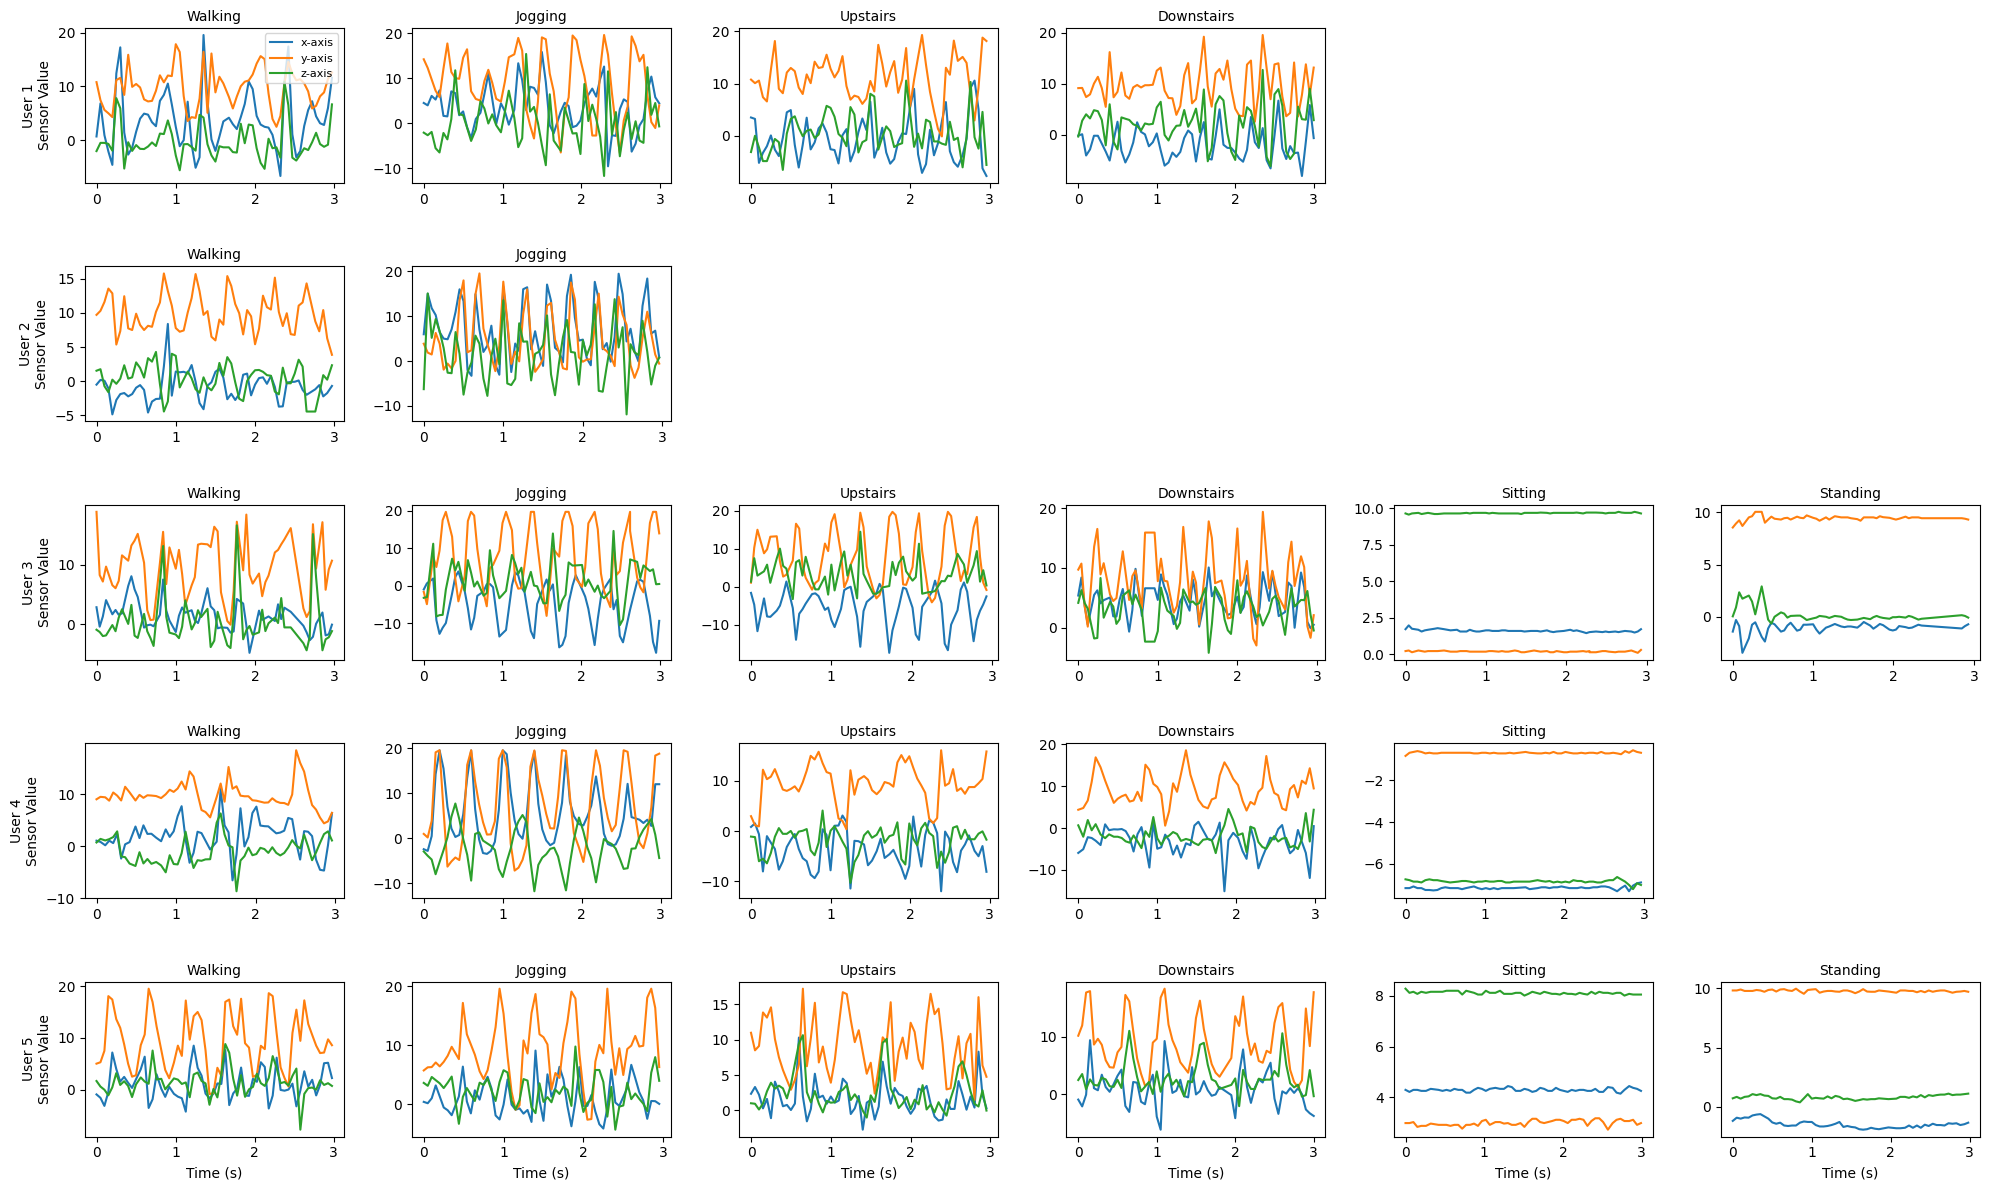

In [15]:
import matplotlib.pyplot as plt

activities = ["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"]
users = df['user'].unique()[:5]  # let's do 5 users for spacing

fig, axes = plt.subplots(len(users), len(activities), figsize=(20, 12), sharex=False, sharey=False)

for i, user in enumerate(users):
    for j, activity in enumerate(activities):
        ax = axes[i, j]
        
        # filter by user + activity
        df_act = df[(df['user'] == user) & (df['activity'] == activity)].copy()
        if df_act.empty:
            ax.axis("off")
            continue
        
        # normalize time to start from 0
        t0 = df_act['timestamp'].iloc[0]
        df_act['time_s'] = (df_act['timestamp'] - t0) / 1e9
        
        # keep only first 3 seconds
        df_act = df_act[df_act['time_s'] <= 3]
        
        # plot 3 axes
        ax.plot(df_act['time_s'], df_act['x-axis'], label="x-axis")
        ax.plot(df_act['time_s'], df_act['y-axis'], label="y-axis")
        ax.plot(df_act['time_s'], df_act['z-axis'], label="z-axis")
        
        # subplot title as the activity
        ax.set_title(activity, fontsize=10, pad=5)  # pad moves the title a bit above
        
        # y-axis label only on first column
        if j == 0:
            ax.set_ylabel(f"User {user}\nSensor Value", fontsize=10)
        
        # x-axis label only on last row
        if i == len(users)-1:
            ax.set_xlabel("Time (s)")
        
        # legend only once per figure to reduce clutter
        if i == 0 and j == 0:
            ax.legend(fontsize=8, loc="upper right")

plt.tight_layout(h_pad=3, w_pad=2)  # more space between rows/columns
plt.show()
